<center><b><font size=6>Unsupervised learning – clustering<b><center>

This notebook ...

0. **Install Dependencies**
1. **Determine the Number of Clusters**
2. **Tune Other Hyperparameters**
3. **Visualize the Clusters**
4. **Cluster Analysis**
5. **Assess Homogeneity and Intent Reflection**
6. **Associate Clusters with Specific Attack Categories**

<center><b><font size=5>Install Dependencies<b><center>

In [4]:
!python ../scripts/install_dependencies.py section3

Installing common packages: pandas, pyarrow
  Using cached pyarrow-12.0.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (39.1 MB)
Installing Section 3 packages: numpy, matplotlib, seaborn, scikit-learn, wordcloud
  Using cached wordcloud-1.9.4-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (488 kB)


In [29]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud

# Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from collections import Counter 
import itertools

<center><b><font size=5>Determine the Number of Clusters<b><center>

Identify the optimal number of clusters using evaluation methods like the Elbow Method or Silhouette Analysis.

**Steps:**

- Evaluate Data for Clustering
- Apply Clustering Evaluation Techniques
- Decide and Document

### Evaluate Data for Clustering

- Preprocess the text sessions (e.g., tokenize and vectorize using TF-IDF or word embeddings).
- Ensure data is normalized and ready for clustering.

In [20]:
SSH_Attacks = pd.read_parquet("../data/processed/ssh_attacks_decoded.parquet")
SSH_Attacks

,session_id,full_session,first_timestamp,Set_Fingerprint
0,0,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:45:11.151186+00:00,"[Defense Evasion, Discovery]"
1,1,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:45:50.396610+00:00,"[Defense Evasion, Discovery]"
2,2,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 09:54:41.863315+00:00,"[Defense Evasion, Discovery]"
3,3,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 10:22:14.623875+00:00,"[Defense Evasion, Discovery]"
4,4,"[enable, system, sh, sh, cat, proc, mounts, bi...",2019-06-04 10:37:19.725874+00:00,"[Defense Evasion, Discovery]"
...,...,...,...,...
233030,233042,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:47:28.217237+00:00,"[Discovery, Persistence]"
233031,233043,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:49:01.009046+00:00,"[Discovery, Persistence]"
233032,233044,"[cat, proc, cp, grep, name, echo, ss, passwd, ...",2020-02-29 23:56:18.827281+00:00,"[Discovery, Persistence]"
233033,233045,"[cat, proc, cp, grep, name, echo, passwd, bash...",2020-02-29 23:56:56.263104+00:00,"[Discovery, Persistence]"


In [6]:

df_features_tfidf_sampled = pd.read_parquet("../data/processed/TFIDF_DATASETS/ssh_attacks_tfidf_sampled.parquet")


X = df_features_tfidf_sampled.drop(columns=["Set_Fingerprint"])
df_features_tfidf_sampled.describe

<bound method NDFrame.describe of                                           Set_Fingerprint    enable    system  \
165488                           [Discovery, Persistence]  0.115984  0.058489   
173336                           [Discovery, Persistence]  0.136394  0.068782   
83077                            [Discovery, Persistence]  0.136394  0.068782   
182184                           [Discovery, Persistence]  0.136394  0.068782   
38052                            [Discovery, Persistence]  0.136394  0.068782   
...                                                   ...       ...       ...   
171360                                           [Impact]  0.000000  0.000000   
132486  [Discovery, Persistence, Defense Evasion, Impa...  0.000000  0.135173   
166018  [Discovery, Persistence, Defense Evasion, Harm...  0.000000  0.105743   
232782        [Discovery, Impact, Execution, Persistence]  0.000000  0.109716   
171506        [Discovery, Impact, Execution, Persistence]  0.000000  0.1414

### Apply Clustering Evaluation Techniques

- Use the Elbow Method:
  - Calculate the sum of squared distances (inertia) for a range of cluster numbers.
  - Plot inertia vs. the number of clusters to identify the "elbow" point.
- Use Silhouette Analysis:
  - Compute the silhouette score for each potential cluster number.
  - Plot silhouette scores to find the number with the highest score.

### Decide and Document

- Select the optimal number of clusters based on the evaluation.
- Visualize and explain the reasoning with supporting metrics and charts.

In [7]:
# Step 1: Elbow Method
n_cluster_list=[]
inertia_list=[]
silhouette_list = []
ri_list = []
ari_list = []

for n_clusters in range(3, 17):
    kmeans_new = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    cl_labels = kmeans_new.fit_predict(X)
        
    silhouette_value= silhouette_score(X, kmeans_new.labels_)
    silhouette_list.append(silhouette_value)

    inertia_list.append(kmeans_new.inertia_)
    n_cluster_list.append(n_clusters)

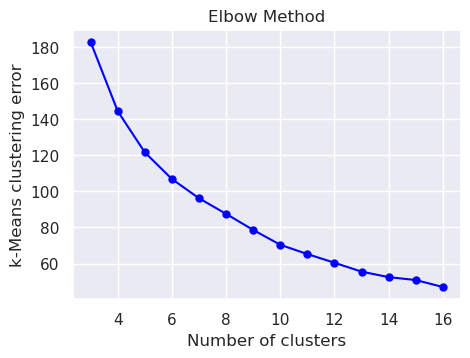

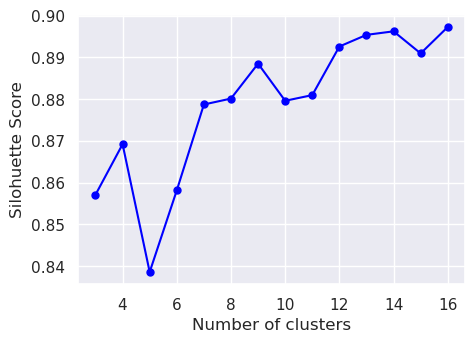

Size of each cluster:  [1670 2061  356   50   17   64   14  212   17  119   70    6   10    6
    9   10]


In [4]:
# Plot k-Means clustering error 
# Set up Seaborn style
sns.set_theme(style="darkgrid")

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, inertia_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('k-Means clustering error')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')
plt.show()

(unique, counts) = np.unique(kmeans_new.labels_, return_counts=True)
print("Size of each cluster: ", counts)

In [8]:
n_cluster_list=[]
silhouette_list_gmm= []
log_l_list=[]

for n_clusters in range(3, 17):
    gmm = GaussianMixture(n_components = n_clusters, random_state=42)
    gmm_label = gmm.fit_predict(X)
      
    silhouette_value = silhouette_score(X, gmm_label)
    silhouette_list_gmm.append(silhouette_value)
    
    log_l_list.append(gmm.score(X))
    n_cluster_list.append(n_clusters)

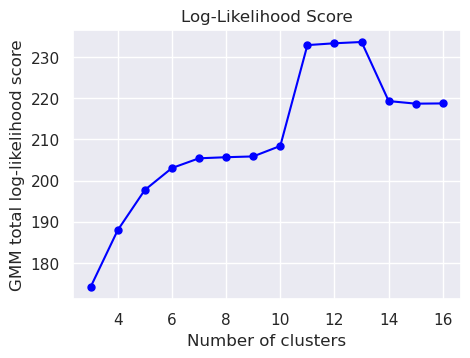

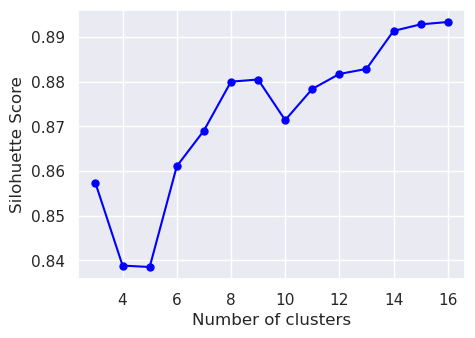

Effetive size of each cluster:  [0.04519292 0.35600085 0.07589    0.44509683 0.01065871 0.00298444
 0.01364315 0.00149222 0.00127904 0.02536773 0.00789827 0.00341079
 0.00341079 0.00554253 0.00127904 0.0008527 ]


In [9]:
# Set up Seaborn style
sns.set_theme(style="darkgrid")

# Plot GMM total log-likelihood score
plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, log_l_list, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('GMM total log-likelihood score')
plt.title('Log-Likelihood Score')
plt.show()

plt.figure(figsize=(5, 3.5))
plt.plot(n_cluster_list, silhouette_list_gmm, marker='o', markersize=5, color='blue')
plt.xlabel('Number of clusters')
plt.ylabel('Silohuette Score')
plt.title('')
plt.show()

# report effective size
print("Effetive size of each cluster: ", gmm.weights_)

<center><b><font size=5>Tune Other Hyperparameters<b><center>

## KMEANS

In [10]:
param_grid_kmeans = {
    'init': ['k-means++', 'random'],
    'n_init':  list(range(10, 21, 2)),
    'max_iter':  list(range(50, 200, 50)),
}

# Create KMeans object
kmeans = KMeans(n_clusters=10, random_state=42)

# Create RandomizedSearchCV object
grid_search_kmeans = GridSearchCV(kmeans, param_grid = param_grid_kmeans, cv=5)

# Fit the randomized search to your data
grid_search_kmeans.fit(X)  # X is your dataset

# Get the best parameters
best_params_kmenas = grid_search_kmeans.best_params_
print("Best parameters:", best_params_kmenas)

Best parameters: {'init': 'k-means++', 'max_iter': 50, 'n_init': 18}


In [11]:
kmeans_tuned = KMeans(n_clusters=10, init=best_params_kmenas['init'], n_init=best_params_kmenas['n_init'], max_iter=best_params_kmenas['max_iter'], random_state=42)
cl_labels_tuned = kmeans_tuned.fit_predict(X)
    
silhouette_value= silhouette_score(X, kmeans_tuned.labels_)

inertia = (kmeans_tuned.inertia_)
print("Silhouette: ", silhouette_value)
print("Inertia: ", inertia)

Silhouette:  0.8795793662649541
Inertia:  70.38620655544014


## GMM

In [12]:
def silhouette_scorer(gmm, X):
    labels = gmm.fit_predict(X)
    return silhouette_score(X, labels)

param_grid_gmm = {
    'init_params': ['kmeans'], 
    'covariance_type': ['full', 'spherical'], # 'tied', 'diag' have been deleted because never selected
    'tol': [1e-3, 1e-4, 1e-5], 
    'max_iter': list(range(50, 300, 50)),
}

# Create GaussianMixture object
gmm = GaussianMixture(n_components=10,random_state=42)

# Create GridSearchCV object
grid_search_gmm = GridSearchCV(gmm, param_grid_gmm, cv=5, scoring = silhouette_scorer)

# Fit the grid search to your data
grid_search_gmm.fit(X)  # X is your dataset

# Get the best parameters
best_params_gmm = grid_search_gmm.best_params_
print("Best parameters:", best_params_gmm)

Best parameters: {'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 50, 'tol': 0.001}


In [13]:
gmm_tuned = GaussianMixture(n_components = 10, random_state=42, init_params=best_params_gmm['init_params'], covariance_type=best_params_gmm['covariance_type'], max_iter=best_params_gmm['max_iter'], tol=best_params_gmm['tol'])
gmm_label_tuned = gmm_tuned.fit_predict(X)
    
silhouette_value = silhouette_score(X, gmm_label_tuned)

log_l_tuned = (gmm_tuned.score(X))

print("Silhouette: ", silhouette_value)
print("Log-l: ", log_l_tuned)

Silhouette:  0.8714027131151205
Log-l:  208.41886022700015


<center><b><font size=5>Visualize the Clusters: t-SNE<b><center>

Use t-SNE or UMAP to create clear visual representations of the clusters.

**Steps:**

- Reduce Dimensionality
- Create Visual Representations
- Analyze and Save

### Reduce Dimensionality

- Apply t-SNE or UMAP to reduce the data to two or three dimensions for visualization.
- Normalize or scale data if required by the algorithm.

In [14]:
#LET'S APPLY THE t-SNE TO THE DATASET, TO REDUCE THE NUMBER OF COMPONENTS

originalDF = pd.DataFrame(X)

tsne = TSNE(n_components=2, random_state=42).fit_transform(originalDF.values)

df_tsne = pd.DataFrame(tsne)
df_tsne

#NOW WE HAVE THE 2 COMPONENTS and WE CAN APPLY IT TO BOTH THE ALGORITHM

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


,0,1
0,-9.186168,12.183332
1,13.230267,2.501328
2,14.983236,0.371518
3,17.068666,0.988171
4,17.002472,-0.311910
...,...,...
4686,-12.544358,18.818552
4687,-24.292097,11.290898
4688,-24.149002,11.131251
4689,-24.445341,11.338045


### Create Visual Representations

- Plot the data points with cluster assignments using a scatter plot:
  - Assign distinct colors to each cluster.
  - Add legends and labels for clarity.

## KMEANS

,x1,x2,cluster
0,-9.186168,12.183332,9
1,13.230267,2.501328,1
2,14.983236,0.371518,1
3,17.068666,0.988171,1
4,17.002472,-0.311910,1
...,...,...,...
4686,-12.544358,18.818552,5
4687,-24.292097,11.290898,5
4688,-24.149002,11.131251,5
4689,-24.445341,11.338045,5


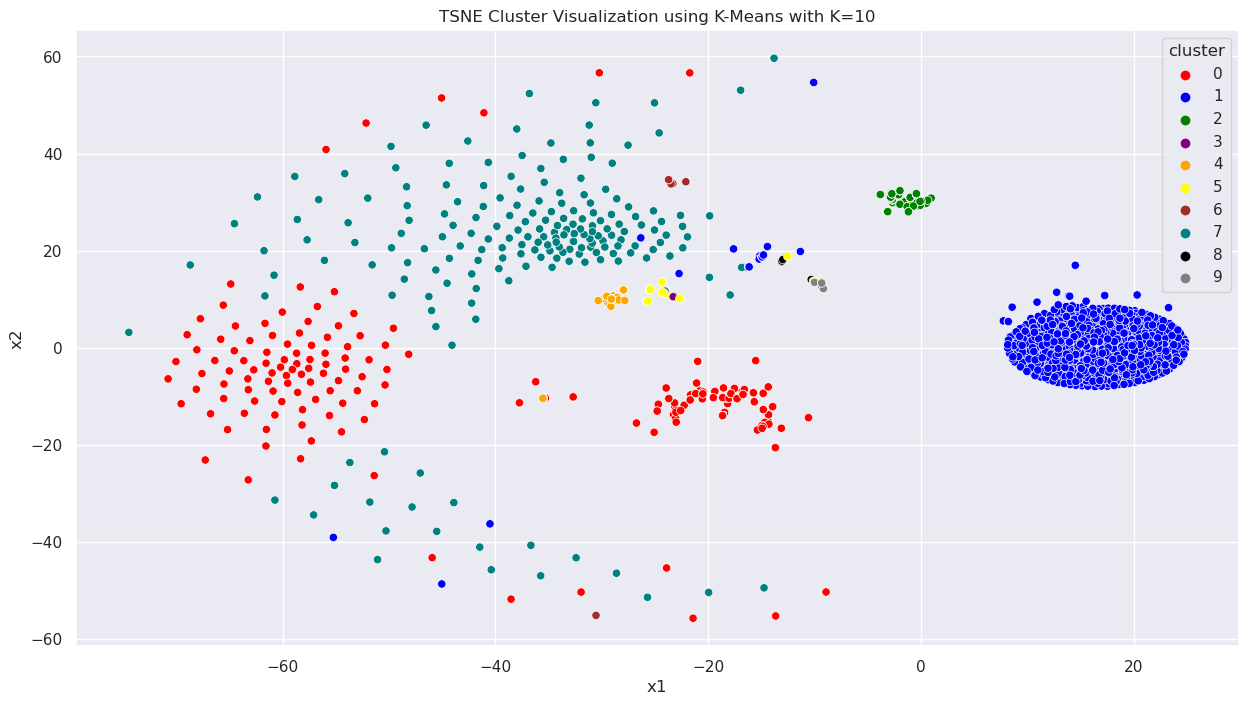

In [15]:
labels_kmeans_tuned = kmeans_tuned.labels_

df_tsne_kmeans = pd.DataFrame(df_tsne)
df_tsne_kmeans["cluster"] = labels_kmeans_tuned
df_tsne_kmeans.columns = ["x1", "x2", "cluster"]


fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_kmeans, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")
ax.set_title('TSNE Cluster Visualization using K-Means with K=10')
df_tsne_kmeans

## GMM

,x1,x2,cluster
0,-9.186168,12.183332,4
1,13.230267,2.501328,3
2,14.983236,0.371518,3
3,17.068666,0.988171,3
4,17.002472,-0.311910,3
...,...,...,...
4686,-12.544358,18.818552,8
4687,-24.292097,11.290898,5
4688,-24.149002,11.131251,7
4689,-24.445341,11.338045,5


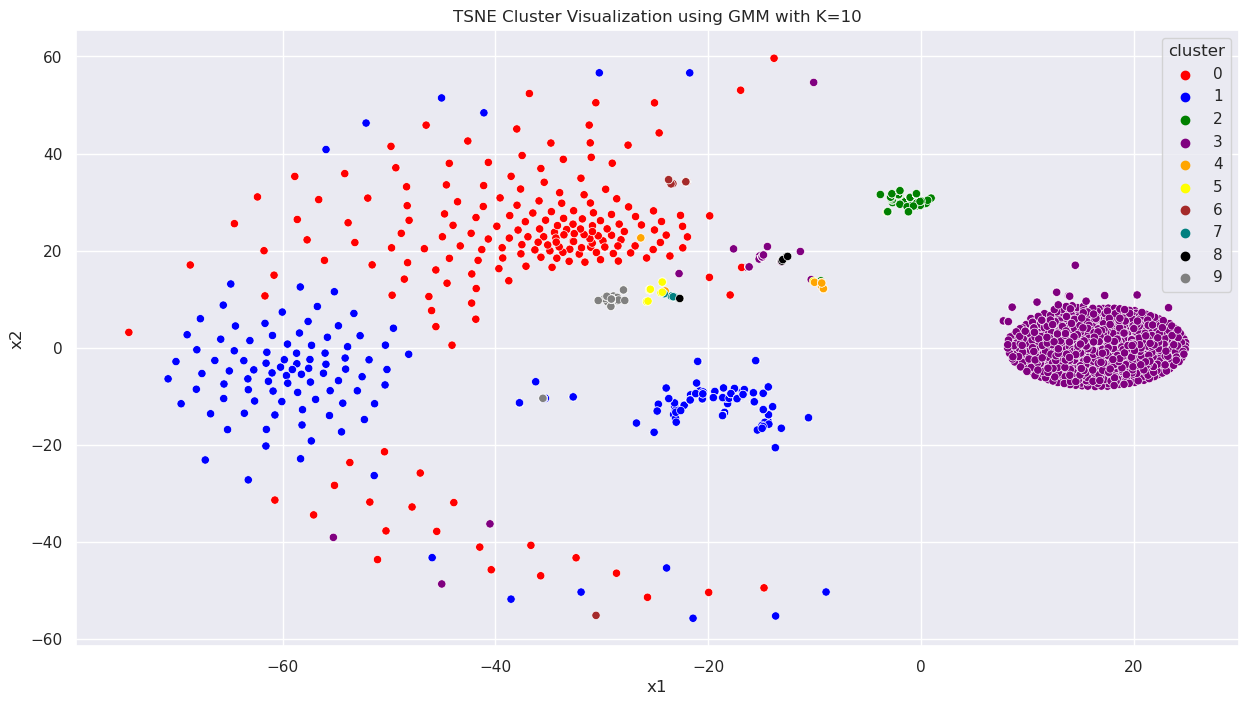

In [16]:
labels_gmm_tuned = gmm_tuned.predict(X)


df_tsne_gmm = pd.DataFrame(df_tsne)
df_tsne_gmm["cluster"] = labels_gmm_tuned
df_tsne_gmm.columns = ["x1", "x2", "cluster"]


fig, ax = plt.subplots(figsize=(15,8))
#custom color palette, to distinguish beter the clusters
cluster_colors = ["red", "blue", "green", "purple", "orange", "yellow", "brown", "teal", "black", "grey"]

sns.scatterplot(data=df_tsne_gmm, x='x1', y='x2', hue='cluster',  palette=cluster_colors, legend="full")
ax.set_title('TSNE Cluster Visualization using GMM with K=10')
df_tsne_gmm

### Analyze and Save

- Highlight overlaps or ambiguous clusters in the visualization.
- Save the plots and include them in your report for analysis.

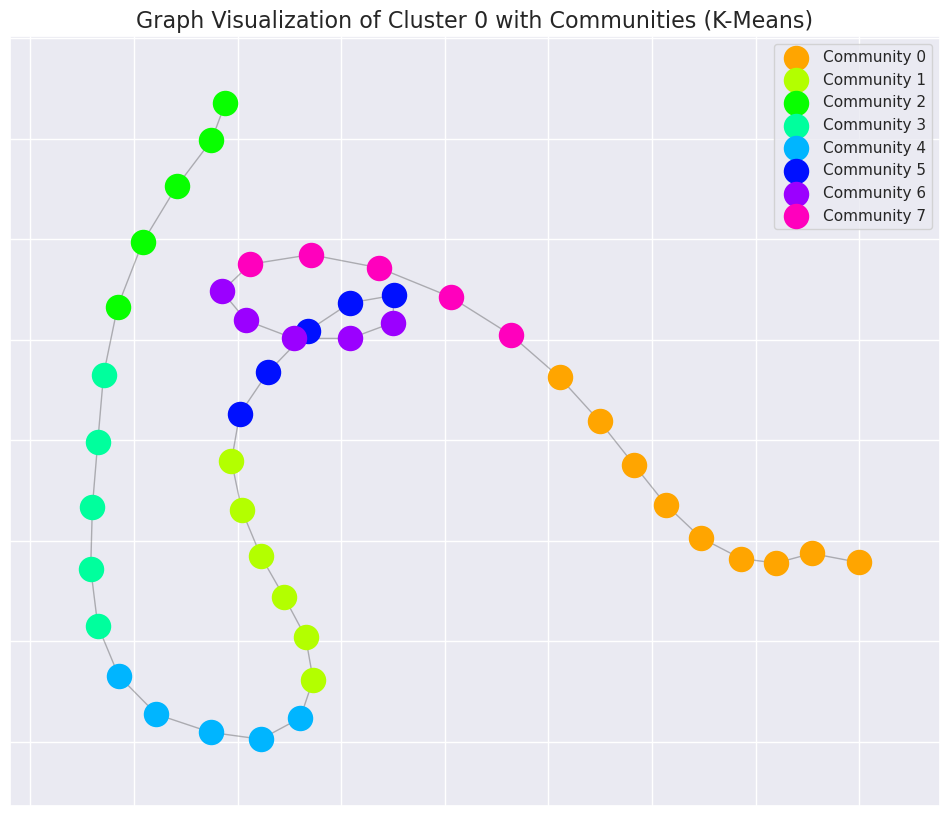

Cluster 0 - K-Means Community Analysis:
Community 0:
['nc', 'nohup', 'mkdir', 'tar', 'passwd', 'tsm', 'unix', 'sleep', 'mv']


Community 1:
['var', 'tmp', 'bs', 'exit', 'count', 'rm']


Community 2:
['proc', 'system', 'enable', 'cat', 'sh']


Community 3:
['dev', 'bin', 'busybox', 'mounts', 'cd']


Community 4:
['dd', 'wget', 'cp', 'echo', 'tftp']


Community 5:
['ls', 'ss', 'uname', 'root', 'name']


Community 6:
['awk', 'chpasswd', 'grep', 'bash', 'head']


Community 7:
['which', 'crontab', 'free', 'print', 'top']




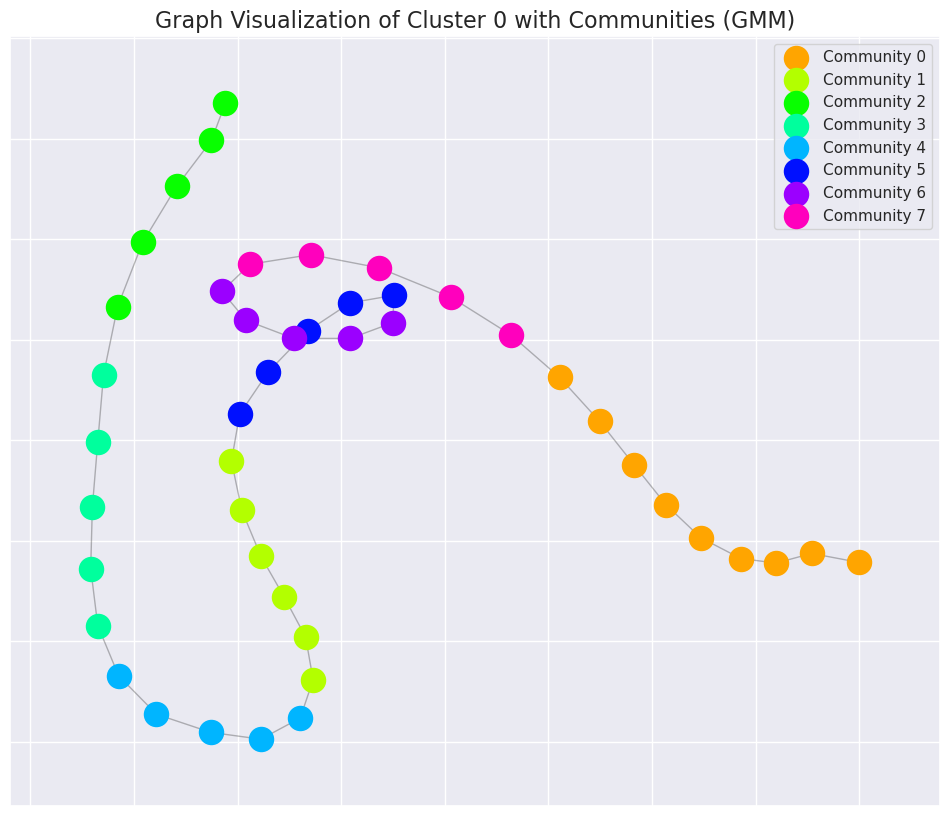

Cluster 0 - GMM Community Analysis:
Community 0:
['nc', 'nohup', 'mkdir', 'tar', 'passwd', 'tsm', 'unix', 'sleep', 'mv']


Community 1:
['var', 'tmp', 'bs', 'exit', 'count', 'rm']


Community 2:
['proc', 'system', 'enable', 'cat', 'sh']


Community 3:
['dev', 'bin', 'busybox', 'mounts', 'cd']


Community 4:
['dd', 'wget', 'cp', 'echo', 'tftp']


Community 5:
['ls', 'ss', 'uname', 'root', 'name']


Community 6:
['awk', 'chpasswd', 'grep', 'bash', 'head']


Community 7:
['which', 'crontab', 'free', 'print', 'top']




In [17]:
# Cluster analysis and fine-grained attack categorization
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

# Example: Analyze Cluster 0 (modify as needed for other clusters)
example_cluster = 0
cluster_indices_kmeans = df_tsne_kmeans[df_tsne_kmeans["cluster"] == example_cluster].index
cluster_sessions_kmeans = df_features_tfidf_sampled.iloc[cluster_indices_kmeans]

# Create a graph for session relationships (K-Means)
G_kmeans = nx.Graph()
for idx, row in cluster_sessions_kmeans.iterrows():
    session_words = row.drop("Set_Fingerprint").index  # Example, replace with meaningful data
    for i in range(len(session_words) - 1):
        G_kmeans.add_edge(session_words[i], session_words[i + 1])

# Use a community detection algorithm
communities_kmeans = greedy_modularity_communities(G_kmeans)

# Visualize the graph with communities
pos_kmeans = nx.spring_layout(G_kmeans, seed=42)
plt.figure(figsize=(12, 10))
colors_kmeans = sns.color_palette('hsv', len(communities_kmeans)).as_hex()
for idx, community in enumerate(communities_kmeans):
    nx.draw_networkx_nodes(G_kmeans, pos_kmeans, nodelist=list(community), node_color=colors_kmeans[idx], label=f'Community {idx}')
nx.draw_networkx_edges(G_kmeans, pos_kmeans, alpha=0.3)
plt.title(f'Graph Visualization of Cluster {example_cluster} with Communities (K-Means)', fontsize=16)
plt.legend()
plt.show()

# Analyze community content for K-Means
print(f"Cluster {example_cluster} - K-Means Community Analysis:")
for idx, community in enumerate(communities_kmeans):
    print(f"Community {idx}:")
    print(list(community)[:10])  # Show first 10 nodes as example
    print("\n")

# Repeat for GMM
example_cluster = 0
cluster_indices_gmm = df_tsne_gmm[df_tsne_gmm["cluster"] == example_cluster].index
cluster_sessions_gmm = df_features_tfidf_sampled.iloc[cluster_indices_gmm]

# Create a graph for session relationships (GMM)
G_gmm = nx.Graph()
for idx, row in cluster_sessions_gmm.iterrows():
    session_words = row.drop("Set_Fingerprint").index  # Example, replace with meaningful data
    for i in range(len(session_words) - 1):
        G_gmm.add_edge(session_words[i], session_words[i + 1])

# Use a community detection algorithm
communities_gmm = greedy_modularity_communities(G_gmm)

# Visualize the graph with communities
pos_gmm = nx.spring_layout(G_gmm, seed=42)
plt.figure(figsize=(12, 10))
colors_gmm = sns.color_palette('hsv', len(communities_gmm)).as_hex()
for idx, community in enumerate(communities_gmm):
    nx.draw_networkx_nodes(G_gmm, pos_gmm, nodelist=list(community), node_color=colors_gmm[idx], label=f'Community {idx}')
nx.draw_networkx_edges(G_gmm, pos_gmm, alpha=0.3)
plt.title(f'Graph Visualization of Cluster {example_cluster} with Communities (GMM)', fontsize=16)
plt.legend()
plt.show()

# Analyze community content for GMM
print(f"Cluster {example_cluster} - GMM Community Analysis:")
for idx, community in enumerate(communities_gmm):
    print(f"Community {idx}:")
    print(list(community)[:10])  # Show first 10 nodes as example
    print("\n")


<center><b><font size=5>Cluster Analysis<b><center>

Examine and interpret each cluster’s defining characteristics using word clouds and frequent terms.

**Steps:**

- Identify Key Characteristics
- Describe Cluster Patterns
- Document Insights

### Identify Key Characteristics

- Extract the most frequent words or phrases in each cluster.
- Generate word clouds to visually represent the distinctive terms for each cluster.

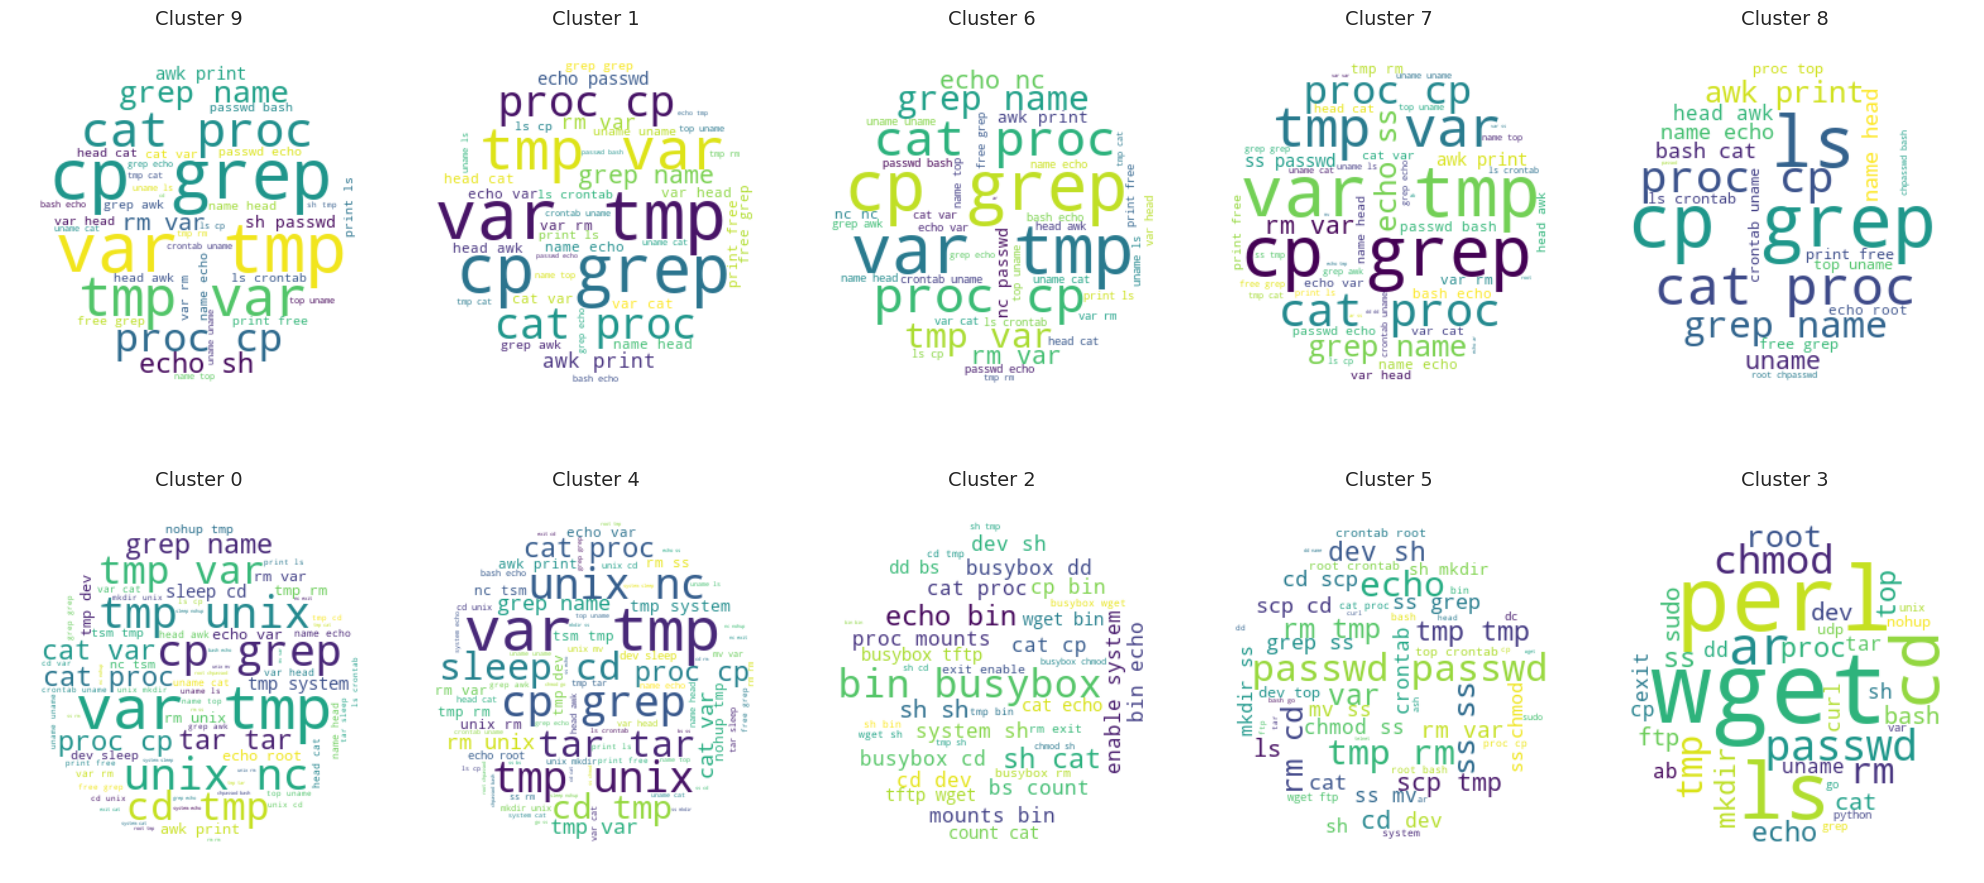

In [27]:


# Create a circular mask
def create_circular_mask(width, height, radius):
    x, y = np.ogrid[:height, :width]
    center_x, center_y = width // 2, height // 2
    mask = (x - center_y) ** 2 + (y - center_x) ** 2 > radius ** 2
    return 255 * mask.astype(int)

# Generate word clouds for clusters using circular masks
def generate_circular_wordclouds(df, labels, session_col="full_session", num_columns=5):
    # Prepare data
    clusters = pd.DataFrame({
        'cluster': labels,
        session_col: df[session_col].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, (list, np.ndarray)) else str(x))
    })

    unique_clusters = clusters['cluster'].unique()
    n_clusters = len(unique_clusters)
    num_rows = (n_clusters + num_columns - 1) // num_columns  # Calculate number of rows

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 10))
    axes = axes.flatten()

    # Circular mask
    mask = create_circular_mask(300, 300, 130)

    for idx, cluster_label in enumerate(unique_clusters):
        # Extract sessions for the cluster
        cluster_sessions = clusters[clusters['cluster'] == cluster_label][session_col]

        # Combine all text in the cluster
        all_words = ' '.join(cluster_sessions)

        # Generate word cloud
        wordcloud = WordCloud(width=400, height=400, background_color='white', colormap="viridis",
                              mask=mask, contour_color='grey').generate(all_words)

        # Plot on the grid
        ax = axes[idx]
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.set_title(f'Cluster {cluster_label}', fontsize=14)
        ax.axis('off')

    # Turn off unused subplots
    for idx in range(len(unique_clusters), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Apply the function to generate circular word clouds
generate_circular_wordclouds(df_features_tfidf_sampled, labels_kmeans_tuned, session_col="full_session", num_columns=5)


### Describe Cluster Patterns

- Analyze relationships or patterns among clusters:
  - Are clusters clearly separated or overlapping?
  - What types of terms dominate each cluster?

### Document Insights

- Summarize findings for each cluster with observations about their unique traits.

<center><b><font size=5>Assess Homogeneity and Intent Reflection<b><center>

Evaluate how well clusters align with intents and assess their homogeneity.

**Steps:**

- Match Clusters to Intents
- Analyze Homogeneity
- Draw Conclusions

### Match Clusters to Intents

- Compare each cluster to the dataset’s labeled intents (e.g., Persistence, Discovery, etc.).
- Use metrics like the homogeneity score or manual inspection to evaluate alignment.

Homogeneity Score: 0.8139

Intent Distribution Per Cluster:

Cluster 0:
Discovery      1667
Execution      1667
Persistence    1666
Other             9
Harmless          7
dtype: int64

Cluster 1:
Discovery          2139
Persistence        2094
Execution            38
Harmless             35
Defense Evasion      11
dtype: int64

Cluster 2:
Discovery          352
Defense Evasion    351
Execution            7
Persistence          3
Other                1
dtype: int64

Cluster 3:
Execution          12
Discovery           9
Harmless            6
Impact              4
Defense Evasion     3
Other               1
dtype: int64

Cluster 4:
Discovery      119
Execution      119
Persistence    118
Other            1
dtype: int64

Cluster 5:
Execution          29
Discovery          23
Defense Evasion    17
Persistence        16
Impact              8
Harmless            6
Other               3
dtype: int64

Cluster 6:
Discovery      64
Persistence    64
dtype: int64

Cluster 7:
Discovery      215
P

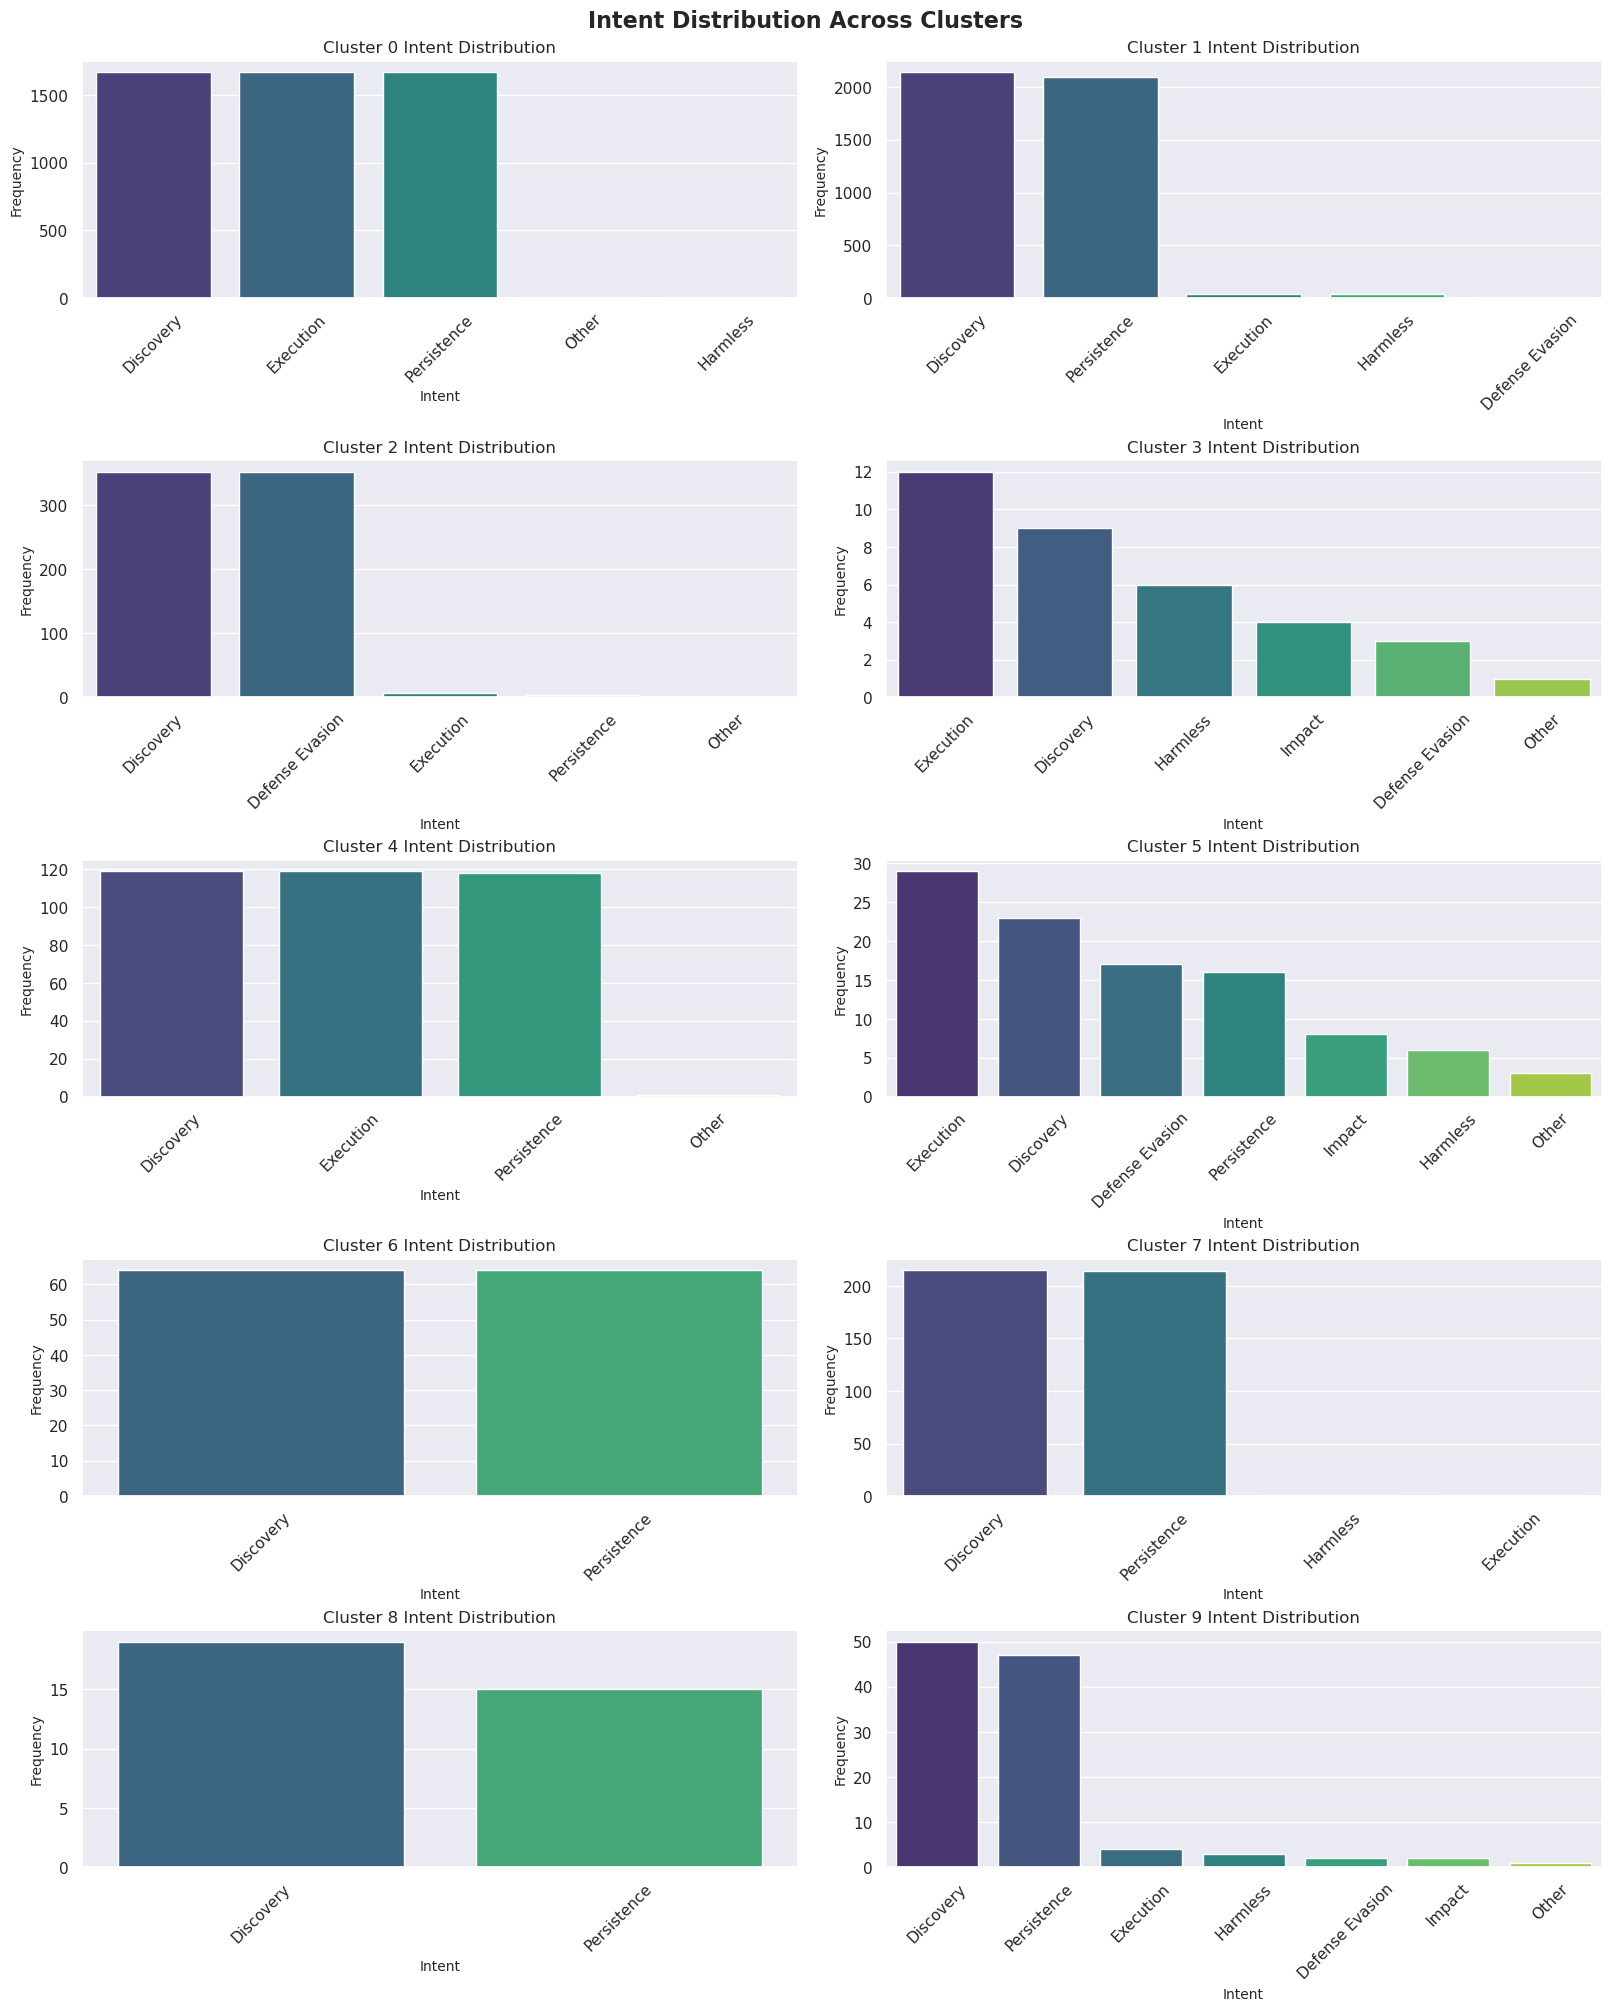

In [31]:
from sklearn.metrics import homogeneity_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import math

def evaluate_cluster_homogeneity(df, labels, intent_col="Set_Fingerprint"):
    """
    Evaluate cluster homogeneity by comparing clusters to labeled intents.

    Args:
        df (pd.DataFrame): The dataset containing the intents.
        labels (list or array): Cluster labels assigned to each session.
        intent_col (str): Column name containing the intents.

    Returns:
        None: Displays metrics and visualizations.
    """
    # Convert intents to strings for homogeneity score calculation
    intents_as_strings = df[intent_col].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
    
    # Calculate homogeneity score
    homogeneity = homogeneity_score(intents_as_strings, labels)
    print(f"Homogeneity Score: {homogeneity:.4f}")

    # Map clusters to intents
    df['cluster'] = labels
    cluster_intent_mapping = df.groupby('cluster')[intent_col].apply(lambda x: list(itertools.chain(*x)))

    # Visualize intent distribution per cluster
    print("\nIntent Distribution Per Cluster:")
    num_clusters = len(cluster_intent_mapping)
    num_columns = 2
    num_rows = math.ceil(num_clusters / num_columns)

    fig, axes = plt.subplots(num_rows, num_columns, figsize=(16, 4 * num_rows), constrained_layout=True)

    for i, (cluster_label, intents) in enumerate(cluster_intent_mapping.items()):
        intent_counts = pd.Series(intents).value_counts()
        print(f"\nCluster {cluster_label}:")
        print(intent_counts)

        row_index = i // num_columns
        col_index = i % num_columns

        sns.barplot(ax=axes[row_index, col_index], x=intent_counts.index, y=intent_counts.values, palette='viridis')
        axes[row_index, col_index].set_title(f'Cluster {cluster_label} Intent Distribution', fontsize=12)
        axes[row_index, col_index].set_xlabel('Intent', fontsize=10)
        axes[row_index, col_index].set_ylabel('Frequency', fontsize=10)
        axes[row_index, col_index].tick_params(axis='x', rotation=45)

    # Hide empty subplots if the total number of clusters is not a multiple of num_columns
    for i in range(len(cluster_intent_mapping), num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])

    plt.suptitle('Intent Distribution Across Clusters', fontsize=16, fontweight='bold')
    plt.show()

# Match clusters to intents and evaluate homogeneity
evaluate_cluster_homogeneity(df_features_tfidf_sampled, labels_kmeans_tuned, intent_col="Set_Fingerprint")


### Analyze Homogeneity

- Check if clusters are homogeneous (single intent) or mixed (multiple intents).
- Record insights into intent distribution within clusters.

### Draw Conclusions

- Discuss the implications of the findings:
  - Are clusters meaningful in terms of attack intents?
  - What could improve clustering accuracy?

<center><b><font size=5>Associate Clusters with Specific Attack Categories<b><center>

Analyze selected clusters to identify finer-grained attack categories and unique behaviors.

**Steps:**

- Select Representative Clusters
- Analyze Cluster Contents
- Relate to Practical Scenarios

### Select Representative Clusters

- Choose a few clusters that show interesting or unique behavior for deeper analysis.


Intent Distribution Per Cluster:

Cluster 0:
Discovery      1667
Execution      1667
Persistence    1666
Other             9
Harmless          7
dtype: int64

Cluster 1:
Discovery          2139
Persistence        2094
Execution            38
Harmless             35
Defense Evasion      11
dtype: int64

Cluster 2:
Discovery          352
Defense Evasion    351
Execution            7
Persistence          3
Other                1
dtype: int64

Cluster 3:
Execution          12
Discovery           9
Harmless            6
Impact              4
Defense Evasion     3
Other               1
dtype: int64

Cluster 4:
Discovery      119
Execution      119
Persistence    118
Other            1
dtype: int64

Cluster 5:
Execution          29
Discovery          23
Defense Evasion    17
Persistence        16
Impact              8
Harmless            6
Other               3
dtype: int64

Cluster 6:
Discovery      64
Persistence    64
dtype: int64

Cluster 7:
Discovery      215
Persistence    214
Harmless

### Analyze Cluster Contents

- Examine the sessions in these clusters:
  - Identify patterns or behaviors that distinguish them.
  - Determine subcategories of attacks within these clusters.

### Relate to Practical Scenarios

- Link findings to real-world attack methodologies:
  - Use graph-based techniques or manual inspection for further refinement.
- Present results with examples and interpretations to showcase finer attack categorization.